#### This project is an approach to the development of plant disease recognition model, based on leaf image classification, by the use of deep convolutional networks. The developed model is able to recognize 38 different types of plant diseases out of of 14 different plants.
#### Plants: ['Tomato',  'Apple',  'Blueberry',  'Grape', 'Peach', 'Corn', 'Cherry', 'Squash', 'Strawberry', 'Pepper,', 'Orange', 'Potato', 'Raspberry', 'Soybean']

The dataset contains:
* 70295 training images
* 17572 testing images

Workflow:
1. Loading the images from the folder resizing them into 128 * 128(256 * 256 takes time for processing) and coverting them to tensors 
2. Building a validation dataset using 0.3% of the total dataset.
3. Loading the data using Batches
4. Trying various CNN architecture
  * Combination of Multilayer CNN with Linear Layers
  * VGG16 using Transfer Learning
5. Selecting the device and loading the data into device i.e (GPU) 
6. Training the model and evaluating the model on test data
7. Saving the Model


## Importing Necessary Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
from tqdm.notebook import tqdm

In [4]:
!pip install jovian --upgrade --quiet

In [5]:
project_name = 'course-project-plant-disease-classification'

In [6]:
data ='../input/new-plant-diseases-dataset/'
os.listdir(data)

['test',
 'new plant diseases dataset(augmented)',
 'New Plant Diseases Dataset(Augmented)']

In [7]:
os.listdir(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)')

['valid', 'train']

In [8]:
os.listdir(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train')

['Tomato___Target_Spot',
 'Tomato___Early_blight',
 'Apple___healthy',
 'Tomato___healthy',
 'Blueberry___healthy',
 'Grape___healthy',
 'Peach___healthy',
 'Corn_(maize)___Common_rust_',
 'Cherry_(including_sour)___Powdery_mildew',
 'Tomato___Leaf_Mold',
 'Apple___Black_rot',
 'Squash___Powdery_mildew',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Strawberry___Leaf_scorch',
 'Pepper,_bell___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Potato___Late_blight',
 'Tomato___Late_blight',
 'Strawberry___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Raspberry___healthy',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Pepper,_bell___Bacterial_spot',
 'Cherry_(including_sour)___healthy',
 'Tomato___Septoria_leaf_spot',
 'Peach___Bacterial_spot',
 'Apple___Cedar_apple_rust',
 'Tomato___Bacterial_spot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Apple___Apple_scab',
 'Grape___Black_rot',
 'Potato___heal

## Number of unique plants

In [9]:
unique_plants = []
cl = os.listdir(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train')
for i in cl:
    x = i.split('_')
    if x[0] not in unique_plants:
        unique_plants.append(x[0])
print("Number of Unique Plants: ",len(unique_plants))
print("Unique Plants: ",unique_plants)

Number of Unique Plants:  14
Unique Plants:  ['Tomato', 'Apple', 'Blueberry', 'Grape', 'Peach', 'Corn', 'Cherry', 'Squash', 'Strawberry', 'Pepper,', 'Orange', 'Potato', 'Raspberry', 'Soybean']


## Loading Training and Test Dataset as Tensor

In [10]:
transform = transforms.Compose(
    [transforms.Resize(size = 128),
     transforms.ToTensor()])

In [11]:
dataset = ImageFolder(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',transform=transform)
test_ds = ImageFolder(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',transform=transform)

In [32]:
print("Number of training images: ",len(dataset))
print("Number of testing images: ",len(test_ds))

Number of training images:  70295
Number of testing images:  17572


## Number of classes

In [13]:
num_classes = dataset.classes
print("Number of classes: ",len(num_classes))
print(num_classes)

Number of classes:  38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mit

## Visualising a single image

In [14]:
image, label  = dataset[0]
print("Image shape:",image.shape)
print("Image Label: ",label)
print("Image Label: ",dataset.classes[label])
print(image)

Image shape: torch.Size([3, 128, 128])
Image Label:  0
Image Label:  Apple___Apple_scab
tensor([[[0.6588, 0.6549, 0.6510,  ..., 0.7373, 0.7333, 0.7176],
         [0.6627, 0.6588, 0.6510,  ..., 0.7373, 0.7373, 0.7294],
         [0.6667, 0.6667, 0.6667,  ..., 0.7333, 0.7294, 0.7294],
         ...,
         [0.4118, 0.4039, 0.3961,  ..., 0.4863, 0.4902, 0.4902],
         [0.4000, 0.4078, 0.4000,  ..., 0.4941, 0.4980, 0.4980],
         [0.4000, 0.4039, 0.4000,  ..., 0.4706, 0.4784, 0.4824]],

        [[0.6431, 0.6392, 0.6353,  ..., 0.7255, 0.7216, 0.7059],
         [0.6471, 0.6431, 0.6353,  ..., 0.7255, 0.7255, 0.7176],
         [0.6510, 0.6510, 0.6510,  ..., 0.7216, 0.7176, 0.7176],
         ...,
         [0.3725, 0.3647, 0.3569,  ..., 0.4235, 0.4275, 0.4275],
         [0.3608, 0.3686, 0.3608,  ..., 0.4314, 0.4353, 0.4353],
         [0.3608, 0.3647, 0.3608,  ..., 0.4078, 0.4157, 0.4196]],

        [[0.7725, 0.7686, 0.7647,  ..., 0.8392, 0.8353, 0.8196],
         [0.7765, 0.7725, 0.7647,  

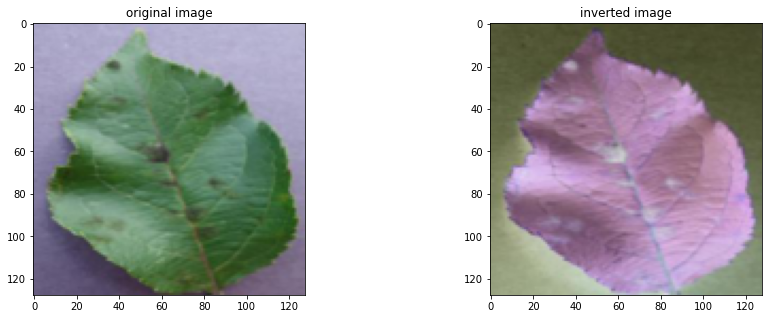

In [15]:
image, label  = dataset[0]
fig,(ax1,ax2) = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
ax1.imshow(image.permute(1,2,0))
ax1.set_title("original image")
ax2.imshow(1-image.permute(1,2,0))
ax2.set_title("inverted image")
plt.show()

## Validation Dataset and Dataloader

In [16]:
random_seed = 42
torch.manual_seed(random_seed)

In [17]:
validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [18]:
batch_size = 64

train_loader = DataLoader(train_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

## Visualising a Batch of images

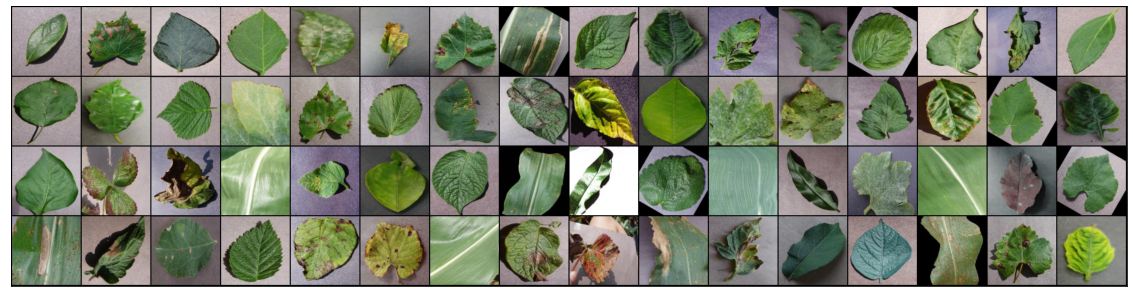

In [19]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

## Building The Model

### Building a Base Image Classification Model

In [20]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Buiding a  CNN model 

In [21]:
class Plant_Disease_Model(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 64*64*64

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 128*32*32

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 256*16*16
        
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 512*8*8
        
        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 1024*4*4
        nn.AdaptiveAvgPool2d(1),
        
        nn.Flatten(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,38)
        )
    
  def forward(self,xb):
    out = self.network(xb)
    return out

### Building a VGG16 model using Transfer Learning

In [22]:
class Plant_Disease_Model1(ImageClassificationBase):
  
  def __init__(self):
    super().__init__()
    self.network = models.vgg16(pretrained=True)
    num_ftrs = self.network.classifier[-1].in_features
    self.network.classifier[-1] = nn.Linear(num_ftrs, 38)
    
  def forward(self,xb):
    out = self.network(xb)
    return out

## Training and Evaluation

In [23]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [24]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

## Using GPU

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [28]:
model = to_device(Plant_Disease_Model1(), device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [29]:
model

Plant_Disease_Model1(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tru

## Training the model

In [30]:
evaluate(model,val_loader)

{'val_loss': 3.728101968765259, 'val_acc': 0.012357954867184162}

In [31]:
history = fit(10, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)


Epoch [0], train_loss: 2.1400, val_loss: 0.9503, val_acc: 0.6936



Epoch [1], train_loss: 0.8770, val_loss: 0.5717, val_acc: 0.8184



Epoch [2], train_loss: 0.6302, val_loss: 0.5694, val_acc: 0.8188



Epoch [3], train_loss: 0.5026, val_loss: 0.5030, val_acc: 0.8404



Epoch [4], train_loss: 0.4378, val_loss: 0.4108, val_acc: 0.8699



Epoch [5], train_loss: 0.4146, val_loss: 0.3649, val_acc: 0.8842



Epoch [6], train_loss: 0.3832, val_loss: 0.3469, val_acc: 0.8911



Epoch [7], train_loss: 0.3483, val_loss: 0.4501, val_acc: 0.8586



Epoch [8], train_loss: 0.3598, val_loss: 0.3334, val_acc: 0.8977



Epoch [9], train_loss: 0.3190, val_loss: 0.2548, val_acc: 0.9192


In [33]:
history += fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)


Epoch [0], train_loss: 0.3440, val_loss: 0.2950, val_acc: 0.9110



Epoch [1], train_loss: 0.3505, val_loss: 0.3646, val_acc: 0.8893



Epoch [2], train_loss: 0.3253, val_loss: 0.3033, val_acc: 0.9047



Epoch [3], train_loss: 0.4457, val_loss: 0.2587, val_acc: 0.9190



Epoch [4], train_loss: 0.2863, val_loss: 0.2741, val_acc: 0.9160


## Plotting accuracy and losses

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

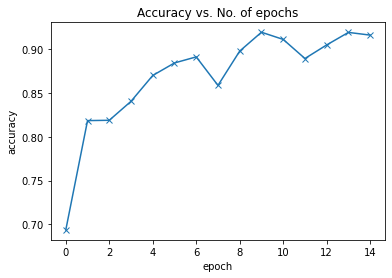

In [36]:
plot_accuracies(history)

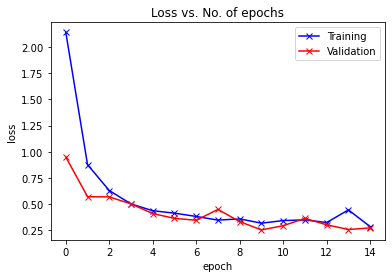

In [37]:
plot_losses(history)

In [38]:
evaluate(model,val_loader)

{'val_loss': 0.2741294205188751, 'val_acc': 0.9159091114997864}

## Evaluation and Prediction on Test Data

In [39]:
x = evaluate(model,test_loader)
x

{'val_loss': 0.27084481716156006, 'val_acc': 0.9128913879394531}

#### **Accuracy of the model on test data :- 91.810%**

## Prediction on some single image of test data

In [40]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: Apple___Apple_scab , Predicted: Apple___Apple_scab


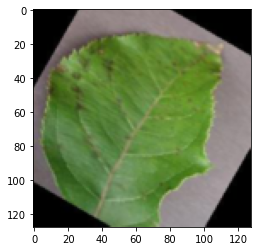

In [41]:
img, label = test_ds[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple___Black_rot , Predicted: Apple___Black_rot


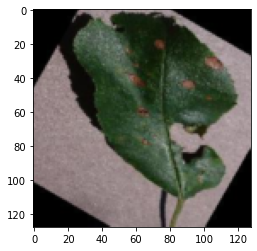

In [42]:
img, label = test_ds[978]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Cherry_(including_sour)___Powdery_mildew , Predicted: Cherry_(including_sour)___Powdery_mildew


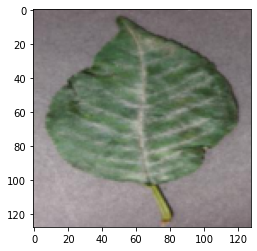

In [43]:
img, label = test_ds[2548]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

## Saving the Model

In [ ]:
torch.save(model.state_dict(), 'plantDisease-vgg16.pth')

#### Adding all details to jovian

In [ ]:
import jovian

In [ ]:
arch = "VGG16"
lrs = [0.001]
epochs = [15]
test_acc = x['val_acc']
test_loss = x['val_loss']
opt = "Adam"

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs,
                       optimizer=opt)

In [ ]:
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)

In [ ]:
jovian.commit(project=project_name)